In [1]:
from CNN_utils import *
import pandas as pd
import keras_tuner as kt
from sklearn.preprocessing import LabelEncoder

tf.config.run_functions_eagerly(True)  # Force eager execution

from tensorflow.keras.utils import to_categorical
import numpy as np


2025-04-13 22:22:44.716470: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 22:22:44.718945: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-13 22:22:44.724960: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-13 22:22:44.747199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744575764.782503   24643 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744575764.79

### 1. + 2. Dataset import and split


Duration of each sample:  3.3391304347826085 s
Train set
Number of elements in each class:  90
Number of sounds in dataset:  360


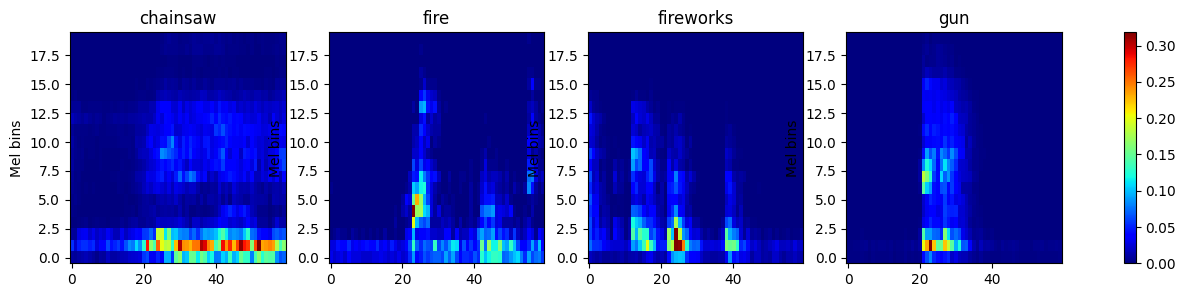

Test set
Number of elements in each class:  30
Number of sounds in dataset:  120


ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


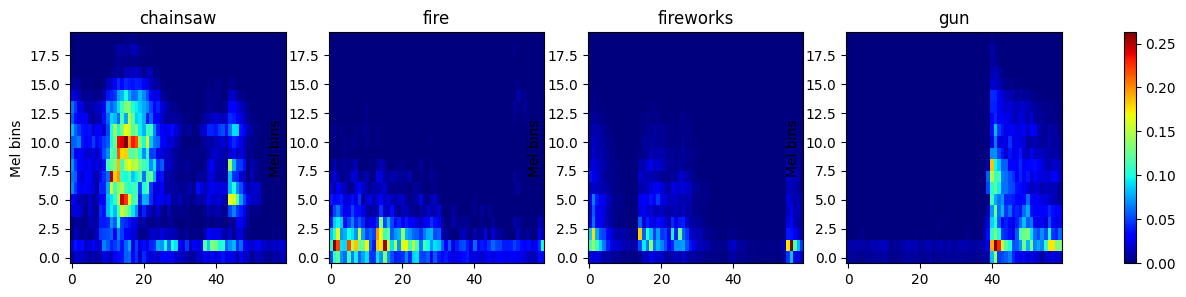

In [2]:
#Physical HP
#------------------------------------
#dtype = np.int16
dtype = np.int16 # Number of removed bits from the int16
Nft = 512
samples_per_melvec = Nft
n_melvec = 60
melvec_height = 20
window_type = "hamming" #hamming, hanning, blackman, rectangular, triangular
sr = 9200


#Visualisation
img_idx = 10


#1. Import classical  - #2. Train-test split
#--------------------------------
duration = n_melvec * Nft / sr 
print("Duration of each sample: ", duration, "s")

print("Train set")
myds, dataset, classnames = get_dataset(path="../datasets/sounds/recorded_sounds/trainset/", filter_str=None,#"_1_",
    Nft=Nft, n_melvec=n_melvec, melvec_height=melvec_height, samples_per_melvec=samples_per_melvec,
    window_type=window_type, sr = sr, dtype=dtype,
    normalize=True, shift_pct=0, verbose=True, img_idx = img_idx, play_sound=True)

print("Test set")
myds_test, dataset_test, _ = get_dataset(path="../datasets/sounds/recorded_sounds/testset/", filter_str=None, #"_1_",
    Nft=Nft, n_melvec=n_melvec, melvec_height=melvec_height, samples_per_melvec=samples_per_melvec,
    window_type=window_type, sr = sr, dtype=dtype,
    normalize=True, shift_pct=0, verbose=True, img_idx = img_idx, play_sound=False)




Dataset Augmentations
pickle_name:  ../datasets/melvecs/HP_tuning/melvecs_int16_512_512_60_20_hamming_9200_time_shift_2_add_bg_3_physical_bg

TRAIN SET
Previously computed dataset successfully loaded!
Shape of feature matrix: (2280, 1200)
Number of labels: 2280
Plotting index: 10 (Aug: 0, Class: chainsaw, Img: 10)
Plotting index: 100 (Aug: 0, Class: fire, Img: 10)
Plotting index: 190 (Aug: 0, Class: fireworks, Img: 10)
Plotting index: 280 (Aug: 0, Class: gun, Img: 10)
Plotting index: 370 (Aug: 1, Class: chainsaw, Img: 10)
Plotting index: 460 (Aug: 1, Class: fire, Img: 10)
Plotting index: 550 (Aug: 1, Class: fireworks, Img: 10)
Plotting index: 640 (Aug: 1, Class: gun, Img: 10)
Plotting index: 730 (Aug: 2, Class: chainsaw, Img: 10)
Plotting index: 820 (Aug: 2, Class: fire, Img: 10)
Plotting index: 910 (Aug: 2, Class: fireworks, Img: 10)
Plotting index: 1000 (Aug: 2, Class: gun, Img: 10)
Plotting index: 1090 (Aug: 3, Class: chainsaw, Img: 10)
Plotting index: 1180 (Aug: 3, Class: fire, Im

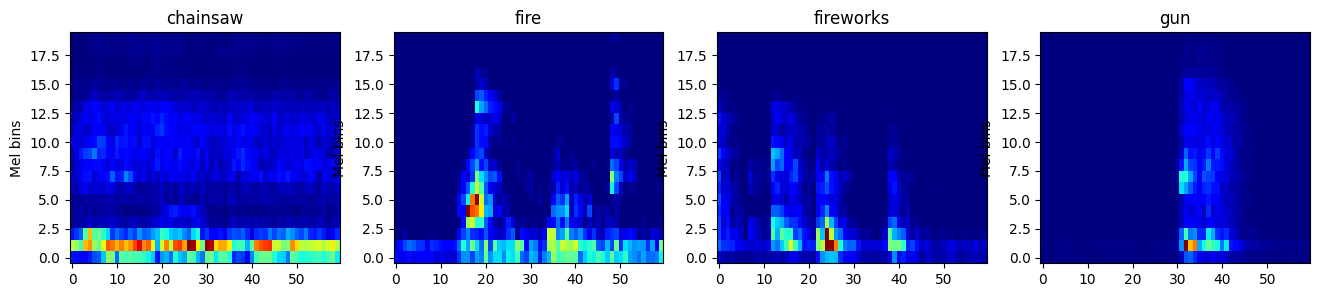

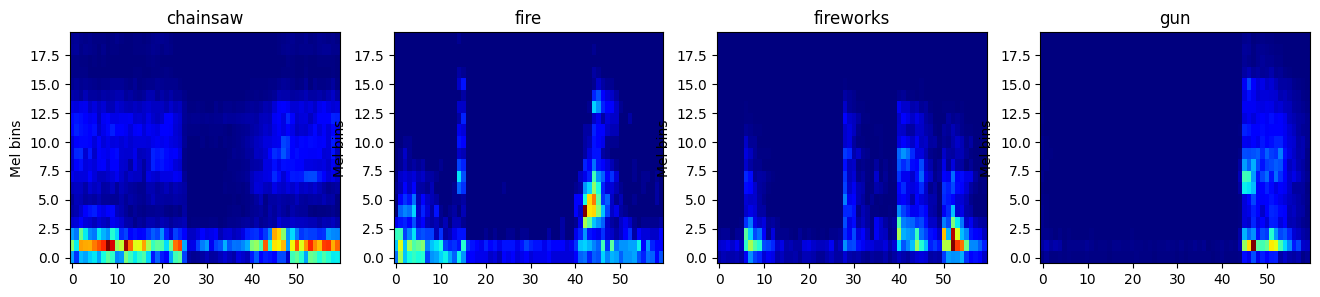

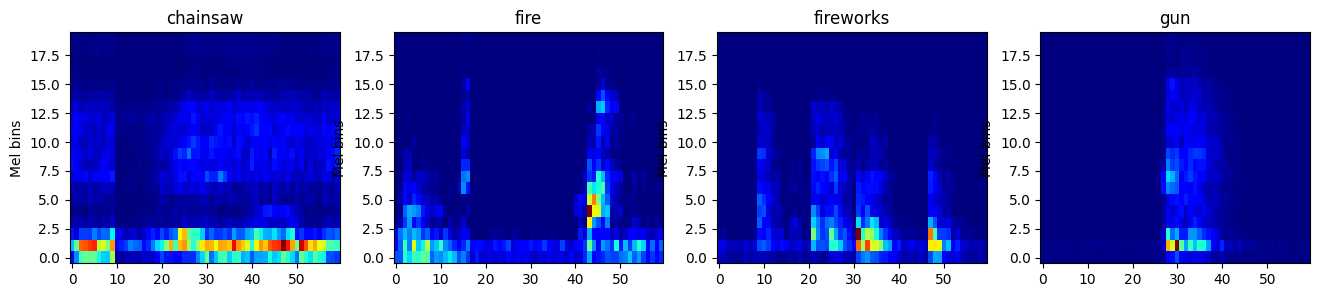

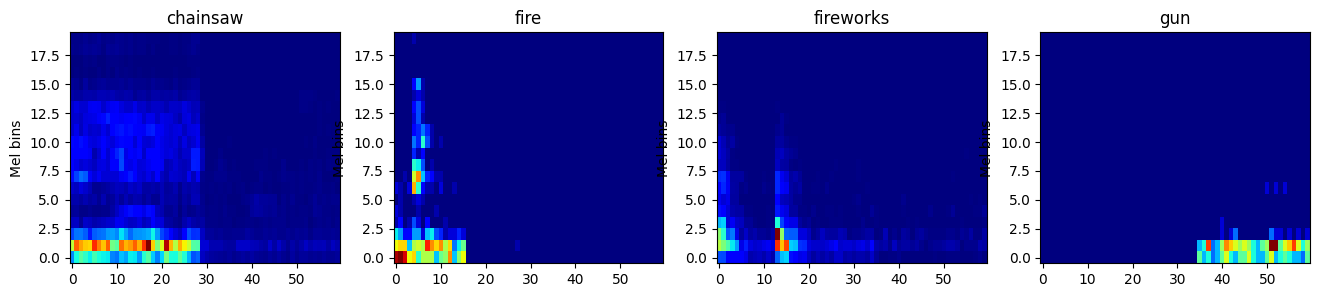

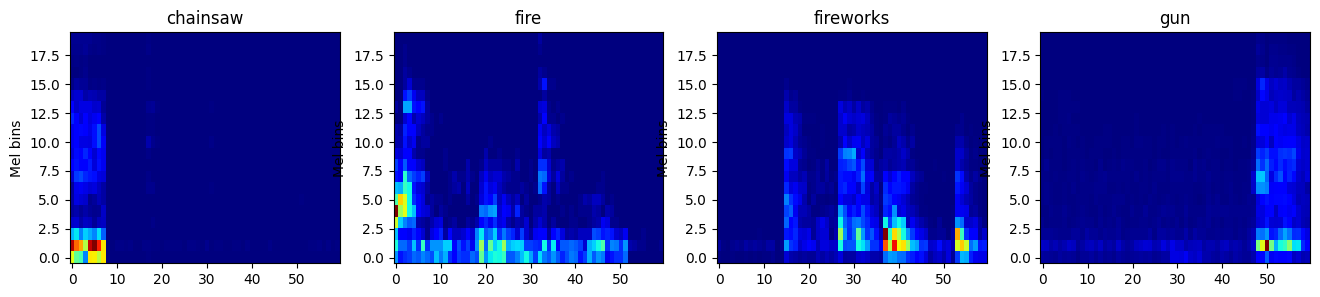

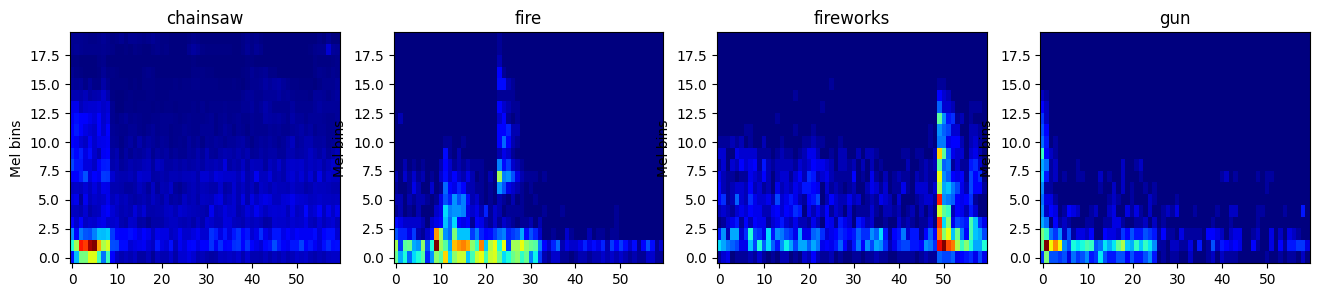

TEST SET
pickle_name_test:  ../datasets/melvecs/HP_tuning/melvecs_test_int16_512_512_60_20_hamming_9200_time_shift_2_add_bg_3_physical_bg
Previously computed dataset successfully loaded!


In [3]:
#3. Dataset augmentations
#----------------------------

img_idx = 45
#CAREFUL: always respect the order
augmentations = ["time_shift", "add_bg", "physical_bg"]
#augmentations = ["add_bg"]

shift_nb = 2                  if "time_shift" in augmentations else 0
bg_amplitude_limit = [0.1, 0.1, 0.316] if "add_bg" in augmentations else []      #0.1: 20dB, 0.316: 5dB
physical_aug = ("physical_bg" in augmentations)

plot_indexes = [0,1,2,3,4,5]
load_matrix = True

print("\nDataset Augmentations")
if "add_bg" in augmentations:
    bg_dataset = Dataset(folder="../datasets/sounds/recorded_sounds/background/", filter_str=None)
else :
    bg_dataset = None

if "physical_bg" in augmentations:
    my_phy_ds, phy_bg_dataset, classnames = get_dataset(path="../datasets/sounds/recorded_sounds/trainset/", filter_str="_background_",
    Nft=Nft, n_melvec=n_melvec, melvec_height=melvec_height, samples_per_melvec=samples_per_melvec,
    window_type=window_type, sr = sr, dtype=dtype,
    normalize=True, shift_pct=0, verbose=False, img_idx = img_idx, play_sound=False)
else :
    my_phy_ds = None
    phy_bg_dataset = None


pickle_name = get_picklename(dtype,Nft,samples_per_melvec,n_melvec,melvec_height,window_type,sr,augmentations,shift_nb,bg_amplitude_limit,physical_aug,
    prefix="../datasets/melvecs/HP_tuning/",
    purpose = "melvecs" # "model"
)
print("pickle_name: ", pickle_name)

#---------------------------------

#Visualisation purposes
img_idx = 10
verbose = True
play_sound = True
print()
print("TRAIN SET")
X_train, y_train = augment_dataset(myds, dataset, classnames, augmentations, melvec_height=melvec_height,
                    shift_nb = shift_nb, #numbers of shifts done
                    bg_dataset = bg_dataset, bg_amplitude_limit=bg_amplitude_limit, #dataset used for background noise, background amplitudes
                    physical_bg_dataset = phy_bg_dataset,my_phy_ds = my_phy_ds, #dataset used for physical background noises
                    verbose=verbose, img_idx=img_idx, aug_indexes=plot_indexes, play_sound=play_sound, #verbose parameters
                    load_matrix=load_matrix, pickle_name=pickle_name) #load and save parameters

print("TEST SET")
plot_indexes = [0]
verbose = False
play_sound = False

pickle_name_test = get_picklename(
    dtype,Nft,samples_per_melvec,n_melvec,melvec_height,window_type,sr,augmentations,shift_nb,bg_amplitude_limit,physical_aug,
    prefix="../datasets/melvecs/HP_tuning/",
    purpose = "melvecs_test" # "model"
)
print("pickle_name_test: ", pickle_name_test)
load_matrix_test = True

#TODO: améliorer time shift pour ne pas en avoir des minuscules!!

X_test, y_test = augment_dataset(myds_test, dataset_test, classnames, augmentations = [], melvec_height=melvec_height,
                                 
                shift_nb = 0, #numbers of shifts done
                bg_dataset = None, bg_amplitude_limit=[], #dataset used for background noise, background amplitudes
                physical_bg_dataset = phy_bg_dataset,my_phy_ds = my_phy_ds, #dataset used for physical background noises
                verbose=verbose, img_idx=img_idx, aug_indexes=plot_indexes, play_sound=play_sound, #verbose parameters
               load_matrix=load_matrix_test, pickle_name=pickle_name_test) #load and save parameters

# Transform the labels to integers and save mapping
label_to_id = {label: i for i, label in enumerate(classnames)}
id_to_label = {i: label for label, i in label_to_id.items()}
y_train = np.array([label_to_id[label] for label in y_train])
y_test = np.array([label_to_id[label] for label in y_test])


### 5. Modelling

In [4]:

#CNN architecture
#----------------------------------------------
#Tuner
epochs=10
validation_split=0.3
patience  = 5
epochs_tuner = 5

#A. HyperResNet
hyperResNet = HyperResNet(input_shape=X_train.shape[1:], classes=4)

#B. HyperEfficientNet
hyperEfficientNet = HyperEfficientNet(input_shape=X_train.shape[1:], classes=4)

#C. HyperXception
hyperXception = HyperXception(input_shape=X_train.shape[1:], classes=4)

#D. Self-made 1
def self_made_builder_factory(input_shape):
    #Enable to pass input_shape to the function
    def self_made_builder(hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=input_shape))

        hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
        hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=512, step=32)
        hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=512, step=32)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) 

        model.add(tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation))
        model.add(tf.keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
        model.add(tf.keras.layers.Dense(4, activation='softmax'))

        opt = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

        model.compile(optimizer=opt,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        return model
    return self_made_builder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Convert labels to numbers

def create_tuner(hypermodel):
    return kt.Hyperband(hypermodel,
                    objective='val_accuracy',
                    max_epochs=epochs_tuner,
                    factor=3,
                    directory='hp_dir',
                    project_name='tuner1',
                    overwrite= True)


#(A: HyperResNet, B: HyperEfficientNet, C: HyperXception, D: self_made_builder)
input_shape = X_train.shape[1:]
builder = self_made_builder_factory(input_shape)
tuner = create_tuner(builder)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

tuner.search(X_train, y_train, epochs=epochs, validation_split=validation_split, callbacks=[stop_early])

Trial 9 Complete [00h 00m 19s]
val_accuracy: 0.3684210479259491

Best val_accuracy So Far: 0.6125730872154236
Total elapsed time: 00h 01m 48s


### 6. Training

In [5]:
#5. Final model
model_name = get_picklename(
    dtype,
    Nft,
    samples_per_melvec,
    n_melvec,
    melvec_height,
    window_type,
    sr,
    augmentations,
    shift_nb,
    bg_amplitude_limit,
    physical_aug,
    prefix="../datasets/models/",
    purpose = "model"
)

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, callbacks=[stop_early])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=validation_split)



Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.5180 - loss: 1.0670 - val_accuracy: 0.5000 - val_loss: 1.4997
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.7813 - loss: 0.5636 - val_accuracy: 0.5146 - val_loss: 1.6756
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8553 - loss: 0.3710 - val_accuracy: 0.5322 - val_loss: 1.5896
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.8692 - loss: 0.3382 - val_accuracy: 0.5789 - val_loss: 1.3370
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.8788 - loss: 0.3010 - val_accuracy: 0.5614 - val_loss: 1.6931
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9340 - loss: 0.1753 - val_accuracy: 0.6301 - val_loss: 1.4043
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9607 - loss: 0.1098 - val_accuracy: 0.5965 - val_loss: 2.1871
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9666 - loss: 0.0887 - val_accuracy: 0.6096 - v

### 8. Final model evaluation

In [6]:
#Final results
#------------------------------

k = 5
epochs_kfold = 10
save_model = True

# Train evaluation -  K-Fold cross-validation
#fold_acc_acc, kfold_recall, kfold_f1 = perform_kfold(hypermodel, X_train, y_train, k=k, epochs=epochs_kfold)
#

# Test evaluation
#train_confmat, train_report, test_accuracy, test_confmat, test_report= evaluate_model(hypermodel, 
#                        X_train, y_train, classnames, X_test, y_test,show_confusion=True)


if (X_test is not None):
    predictions = hypermodel.predict(X_test)
    eval_result = hypermodel.evaluate(X_test, y_test)
    print("[test loss, test accuracy]:", eval_result)

if save_model:
    model_name = get_picklename(
        dtype,
        Nft,
        samples_per_melvec,
        n_melvec,
        melvec_height,
        window_type,
        sr,
        augmentations,
        shift_nb,
        bg_amplitude_limit,
        physical_aug,
        prefix="../datasets/models/",
        purpose = "model"
    )
    model_name += "model_3_thursday_2" 
    #Add _train_{kfold_acc}_test_{test_accuracy} to the name
    model_name += "_train_{:.0f}_test_{:.0f}".format(np.mean(fold_acc_acc*100), test_accuracy*100)

    #Check if the model already exists
    if os.path.exists(model_name + ".h5"):
        print("Model already exists!!")
        model_name = model_name + "_new"
    print("Saving model to: ", model_name)
    hypermodel.save(model_name + ".h5")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6990 - loss: 1.6713
[test loss, test accuracy]: [1.7005810737609863, 0.6666666865348816]


NameError: name 'fold_acc_acc' is not defined

In [7]:
'''
def evaluate_tuner(epochs, validation_split, patience, epochs_tuner,y_train):

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)  # Convert labels to numbers


    input_shape = X_train.shape[1:]
    builder = self_made_builder_factory(input_shape)
    tuner = create_tuner(builder)

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

    tuner.search(X_train, y_train, epochs=epochs, validation_split=validation_split, callbacks=[stop_early])

    best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, callbacks=[stop_early])

    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))

    hypermodel = tuner.hypermodel.build(best_hps)

    # Retrain the model
    hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=validation_split)


    k = 5
    epochs_kfold = 10
    save_model = False

    # Train evaluation -  K-Fold cross-validation
    kfold_acc, kfold_recall, kfold_f1 = perform_kfold(hypermodel, X_train, y_train, k=k, epochs=epochs_kfold)


    # Test evaluation
    train_confmat, train_report, test_accuracy, test_confmat, test_report = evaluate_model(hypermodel, 
                            X_train, y_train, classnames, X_test, y_test,show_confusion=False)
    
    return kfold_acc, test_accuracy


epochs_tab = [1,2,3,4,5,6,7,8,9,10]
#epochs_tuner_tab = [1,2,3,4,5]
epochs_tuner_tab = [3]
validation_split = 0.2
patience = 5

kfold_acc_res = []
test_accuracy_res = []

for epochs in epochs_tab:
    for epochs_tuner in epochs_tuner_tab:
        print("EPOCHS: ", epochs)
        kfold_acc, test_accuracy = evaluate_tuner(epochs, validation_split, patience, epochs_tuner, y_train, )
        print(f"Epochs: {epochs}, Tuner Epochs: {epochs_tuner}, K-Fold Accuracy: {kfold_acc}, Test Accuracy: {test_accuracy}")
        kfold_acc_res.append(kfold_acc)
        test_accuracy_res.append(test_accuracy)


name = "tuner_tab_3"

#Save reult for epochs_tab
df = pd.DataFrame({
    'epochs': epochs_tab,
    'kfold_acc': kfold_acc_res,
    'test_accuracy': test_accuracy_res
})
df.to_csv(f"../datasets/GSresults/GS_results_{name}.csv", index=False)
plot_results(epochs_tab, kfold_acc_res = kfold_acc_res, test_accuracy_res = test_accuracy_res, name= name, xlabel="# epochs", title="performances", prefix="../datasets/GSresults/")
"""

#Save reult for epochs_tuner_tab
df = pd.DataFrame({
    'epochs_tuner': epochs_tuner_tab,
    'kfold_acc': kfold_acc_res,
    'test_accuracy': test_accuracy_res
})

df.to_csv(f"../datasets/GSresults/GS_results_{name}.csv", index=False)
plot_results(epochs_tab, kfold_acc_res = kfold_acc_res, test_accuracy_res = test_accuracy_res, name= name, xlabel="# epochs", title="performances", prefix="../datasets/GSresults/")
"""
'''

'\ndef evaluate_tuner(epochs, validation_split, patience, epochs_tuner,y_train):\n\n    label_encoder = LabelEncoder()\n    y_train = label_encoder.fit_transform(y_train)  # Convert labels to numbers\n\n\n    input_shape = X_train.shape[1:]\n    builder = self_made_builder_factory(input_shape)\n    tuner = create_tuner(builder)\n\n    stop_early = tf.keras.callbacks.EarlyStopping(monitor=\'val_loss\', patience=patience)\n\n    tuner.search(X_train, y_train, epochs=epochs, validation_split=validation_split, callbacks=[stop_early])\n\n    best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]\n\n    model = tuner.hypermodel.build(best_hps)\n    history = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, callbacks=[stop_early])\n\n    val_acc_per_epoch = history.history[\'val_accuracy\']\n    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1\n    print(\'Best epoch: %d\' % (best_epoch,))\n\n    hypermodel = tuner.hypermodel.build(best_hps)\